# PREVENDO O RISCO DE INADIMPLÊNCIA NO CRÉDITO RESIDENCIAL

### FEATURE ENGINEERING

#### Udacity - Engenheiro de Machine Learning
Vinicius Ferreira Santos - vyniciuss@gmail.com

## HOME CREDIT


### Importando as bibliotecas

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
#Classes utilitárias
from helper import *
from PipelineBuilder import *
import warnings
warnings.filterwarnings("ignore")
import gc
import pickle

C:\Users\vynic\Anaconda3\envs\py36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#carregando os dados de treinamento
data_train = pd.read_csv("data/application_train.csv")
train_ids = data_train['SK_ID_CURR']
train_labels = data_train['TARGET']
features_train = data_train.drop(columns = ['SK_ID_CURR', 'TARGET'])


# Sucesso - Exibindo o primeiro registro
display(features_train.head(n=1))

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


## Preparar os dados



### Preencher valores ausentes(com média, zero...) ou removê-los.


Antes de iniciar a engenharia de features, preciso resolver um problema dectado na análise exploratória referente a grande quantidade de dados ausentes. Para o classificador não entender que a ausência de dados é um padrão interessante, irei remover as features que apresentarem mais que 60% de dados ausentes. Para as features numéricas que apresentarem menos que 60% de dados ausentes, será imputada a mediana, a fim de evitar problemas provenientes das possíveis distorções nas distribuições e para as features categoricas, será utilizado uma regressão logística para tentar prever o valor ausente. 

In [3]:
features_train = features_train.loc[:, features_train.isnull().mean() < .6]
display(features_train.head(n=1))

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


O processo de remoção eliminou 17 features do conjunto de dados.

### Criando/Transformando features e Fixando ruídos

In [4]:
def transformando_e_criando_features(df):
    # recuperando nome das features categóricas
    cat_attribs = nomes_atributos_categoricos(df)
    # converte as colunas object em str
    df[cat_attribs] = df[cat_attribs].astype(str)
    # removendo dado inválido que representa mais de mil anos de emprego
    df["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)
    # variáveis financeiras tem uma distribuição log-normal
    df['AMT_INCOME_TOTAL_LOG'] = np.log(df['AMT_INCOME_TOTAL'])
    df['AMT_CREDIT_LOG'] = np.log(df['AMT_CREDIT'])
    df['AMT_ANNUITY_LOG'] = np.log(df['AMT_ANNUITY'])
    #criando colunas e transformando datas em dias para anos
    df['AGE'] = (abs(df['DAYS_BIRTH']) / 365).astype(np.int64)
    df['YEAR_EMPLOYED'] = (abs(df['DAYS_EMPLOYED']) / 365).fillna(0).astype(np.int64)
    df['YEAR_REGISTRATION'] = (abs(df['DAYS_REGISTRATION']) / 365).astype(np.int64)


In [5]:
transformando_e_criando_features(features_train)    
cat_attribs = nomes_atributos_categoricos(features_train)    
num_attribs = nomes_atributos_numericos(features_train)
numeric_features = features_train[num_attribs]
gc.collect()

66

### Combinando features numéricas

In [6]:
combined_features = {'CREDIT_PER_INCOME': [numeric_features.columns.get_loc('AMT_CREDIT'), 
                                           numeric_features.columns.get_loc('AMT_INCOME_TOTAL')],
                     
                     'CREDIT_PER_MEMBER': [numeric_features.columns.get_loc('AMT_CREDIT'),
                                           numeric_features.columns.get_loc('CNT_FAM_MEMBERS')],
                     
                     'AMT_CREDIT_PER_ANNUITY': [numeric_features.columns.get_loc('AMT_CREDIT'),
                                                numeric_features.columns.get_loc('AMT_ANNUITY')],
                     
                     'ANNUITY_PER_INCOME': [numeric_features.columns.get_loc('AMT_ANNUITY'),
                                                numeric_features.columns.get_loc('AMT_INCOME_TOTAL')], 
                     
                     'AMT_INCOME_TOTAL_PER_AGE': [numeric_features.columns.get_loc('AMT_INCOME_TOTAL'),
                                                numeric_features.columns.get_loc('AGE')],
                     
                     'AMT_INCOME_TOTAL_PER_MEMBER': [numeric_features.columns.get_loc('AMT_INCOME_TOTAL'),
                                                numeric_features.columns.get_loc('CNT_FAM_MEMBERS')],                    
                     
                     'AMT_CREDIT_PER_AGE': [numeric_features.columns.get_loc('AMT_CREDIT'),
                                               numeric_features.columns.get_loc('AGE')]
                     }


pipelineBuilder = PipelineBuilder()
num_pipeline = pipelineBuilder.build_numeric_pipeline(num_attribs, combined_features = combined_features)

data_attr_combinados = num_pipeline.fit_transform(features_train)
print(data_attr_combinados.shape)

data_attr_combinados = pd.DataFrame(
    data_attr_combinados,
    columns=list(features_train[num_attribs].columns)+num_pipeline.named_steps['attribs_adder'].name_combined_features)
data_attr_combinados.head()

(307511, 101)


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,AGE,YEAR_EMPLOYED,YEAR_REGISTRATION,CREDIT_PER_INCOME,CREDIT_PER_MEMBER,AMT_CREDIT_PER_ANNUITY,ANNUITY_PER_INCOME,AMT_INCOME_TOTAL_PER_AGE,AMT_INCOME_TOTAL_PER_MEMBER,AMT_CREDIT_PER_AGE
0,-0.577538,0.142129,-0.478095,-0.166143,-0.507236,-0.149452,1.506880,0.755835,0.379837,0.579154,...,-1.542169,-0.631408,-0.432130,-0.724863,0.318998,-0.658380,-0.623342,0.559964,1.079119,0.150218
1,-0.577538,0.426792,1.725450,0.592683,1.600873,-1.252750,-0.166821,0.497899,1.078697,1.790855,...,0.130831,-0.311701,-1.054096,0.309764,1.245926,1.868793,-0.515077,0.255417,0.413262,1.333762
2,-0.577538,-0.427196,-1.152888,-1.404669,-1.092145,-0.783451,-0.689509,0.948701,0.206116,0.306869,...,0.716381,-0.791261,-0.224808,-0.727796,-0.729293,-0.206075,-0.855733,-0.426468,-0.252595,-1.145904
3,-0.577538,-0.142533,-0.711430,0.177874,-0.653463,-0.928991,-0.680114,-0.368597,-1.375829,0.369143,...,0.716381,0.487567,1.330108,-0.610250,-0.646922,-1.416070,0.412075,-0.238218,-0.252595,-0.821870
4,-0.577538,-0.199466,-0.213734,-0.361749,-0.068554,0.563570,-0.892535,-0.368129,0.191639,-0.307263,...,0.883681,0.487567,-0.224808,0.098394,0.729683,0.236352,-0.010214,-0.288418,0.280091,-0.491207


### Criando features polinomiais

In [7]:
name_poly_features = ['AMT_CREDIT','AMT_INCOME_TOTAL','DAYS_BIRTH', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
index_poly_features = [features_train.columns.get_loc('AMT_CREDIT'), 
                       features_train.columns.get_loc('AMT_INCOME_TOTAL'),
                       features_train.columns.get_loc('DAYS_BIRTH'),
                       features_train.columns.get_loc('EXT_SOURCE_1'),
                       features_train.columns.get_loc('EXT_SOURCE_2'),
                       features_train.columns.get_loc('EXT_SOURCE_3')]

poly_features = {'POLY_FEATURES': [name_poly_features, index_poly_features]} 

pipelineBuilder = PipelineBuilder()
num_pipeline = pipelineBuilder.build_numeric_pipeline(num_attribs, poly_features = poly_features)

data_attr_combinados = num_pipeline.fit_transform(features_train)
print(data_attr_combinados.shape)
data_attr_combinados = pd.DataFrame(
    data_attr_combinados,
    columns=list(features_train[num_attribs].columns)+num_pipeline.named_steps['attribs_adder'].name_created_poly_features)
data_attr_combinados.head()


(307511, 178)


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,EXT_SOURCE_1^3,EXT_SOURCE_1^2 EXT_SOURCE_2,EXT_SOURCE_1^2 EXT_SOURCE_3,EXT_SOURCE_1 EXT_SOURCE_2^2,EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3,EXT_SOURCE_1 EXT_SOURCE_3^2,EXT_SOURCE_2^3,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_3^3
0,-0.577538,0.142129,-0.478095,-0.166143,-0.507236,-0.149452,1.506880,0.755835,0.379837,0.579154,...,-0.138125,-0.139507,-0.331927,-0.122141,-0.361642,-0.950897,-0.082419,-0.253713,-0.766542,-0.511400
1,-0.577538,0.426792,1.725450,0.592683,1.600873,-1.252750,-0.166821,0.497899,1.078697,1.790855,...,-0.115212,-0.116156,-0.158035,-0.107831,-0.210388,-0.077507,-0.078521,-0.207256,-0.465811,0.263710
2,-0.577538,-0.427196,-1.152888,-1.404669,-1.092145,-0.783451,-0.689509,0.948701,0.206116,0.306869,...,-0.121028,-0.112557,-0.191156,-0.095412,-0.162474,-0.193295,-0.068363,-0.122130,-0.096275,0.051387
3,-0.577538,-0.142533,-0.711430,0.177874,-0.653463,-0.928991,-0.680114,-0.368597,-1.375829,0.369143,...,-0.121028,-0.112557,-0.191156,-0.095412,-0.162474,-0.193295,-0.068363,-0.122130,-0.096275,0.051387
4,-0.577538,-0.199466,-0.213734,-0.361749,-0.068554,0.563570,-0.892535,-0.368129,0.191639,-0.307263,...,-0.121028,-0.112557,-0.191156,-0.095412,-0.162474,-0.193295,-0.068363,-0.122130,-0.096275,0.051387


### OneHotEncoder para features categóricas


In [8]:
pipelineBuilder = PipelineBuilder()
cat_pipeline = pipelineBuilder.build_cat_pipeline(cat_attribs)
data_attr_combinados = cat_pipeline.fit_transform(features_train)
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
attributes = []
for itens, feature in zip(cat_encoder.categories_, cat_attribs):
    for item in itens:
        attributes.append('{}_{}'.format(feature, item))        
        
data_attr_combinados = pd.DataFrame(data_attr_combinados, columns= attributes)
data_attr_combinados.head()        

,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


### Transformando os dados

In [9]:
pipelineBuilder = PipelineBuilder()
full_pipeline = pipelineBuilder.build_full_pipeline(cat_attribs, num_attribs,
                                                                  poly_features=poly_features, 
                                                                   combined_features = combined_features)
#transformando as features
features_attr_combinados = full_pipeline.fit_transform(features_train)
#recuperando os nomes das features polinomias criadas
poly_names = full_pipeline.transformer_list[0][1].named_steps['attribs_adder'].name_created_poly_features
#recuperando os nomes das features combinadas criadas
combined_names = full_pipeline.transformer_list[0][1].named_steps['attribs_adder'].name_combined_features
#recuperando os nomes das features categóricas após onehotencoding
cat_encoder = full_pipeline.transformer_list[1][1].named_steps["cat_encoder"]
cat_names = []
for itens, feature in zip(cat_encoder.categories_, cat_attribs):
    for item in itens:
        cat_names.append('{}_{}'.format(feature, item)) 
#refazendo o dataframe com os nomes das features
data_attr_combinados = pd.DataFrame(
    features_attr_combinados,
    columns=list(features_train[num_attribs].columns)+poly_names
                + combined_names
                + cat_names)

data_attr_combinados.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan
0,-0.577538,0.142129,-0.478095,-0.166143,-0.507236,-0.149452,1.506880,0.755835,0.379837,0.579154,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,-0.577538,0.426792,1.725450,0.592683,1.600873,-1.252750,-0.166821,0.497899,1.078697,1.790855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.577538,-0.427196,-1.152888,-1.404669,-1.092145,-0.783451,-0.689509,0.948701,0.206116,0.306869,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,-0.577538,-0.142533,-0.711430,0.177874,-0.653463,-0.928991,-0.680114,-0.368597,-1.375829,0.369143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,-0.577538,-0.199466,-0.213734,-0.361749,-0.068554,0.563570,-0.892535,-0.368129,0.191639,-0.307263,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


### Separando em dados treino e teste

In [10]:
x_train, x_test, y_train, y_test = train_test_split(data_attr_combinados, train_labels,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=train_labels)

### Realizando redução de dimensionalidade

Nesta seção, irei utilizar a análise de componentes principais (PCA), a fim reduzir o número de features que, após as transformações necessárias, pulou de 103 para 326. Outro objetivo do PCA é a possibilidade de descobrir qual dimensão dos dados melhor maximizam a variância das features.

Para descobrir o número ideal de dimensões, irei realizar uma pesquisa do melhor ajuste com o GridSearch utilizando uma randomforest.

In [13]:
pipe = Pipeline([
    ('reduce_dim', PCA()),
    ('classify', RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1))
])

n_dimensoes = [2, 4, 8, 10, 15, 20, 30]
param_grid = [
    {
        'reduce_dim': [PCA()],
        'reduce_dim__n_components': n_dimensoes
    }
]

grid = GridSearchCV(pipe, cv=5, n_jobs=1, param_grid=param_grid)
grid.fit(x_train, y_train)
mean_scores = np.array(grid.cv_results_['mean_test_score'])

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   47.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   46.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   45.7s finished
[Parall

### Visualizando a acurácia por dimensão

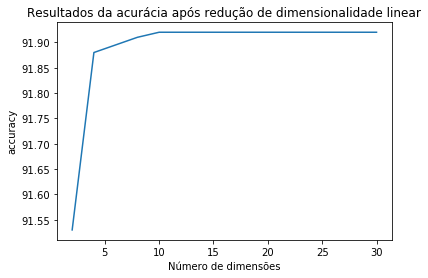

O número de dimensões ideal é 15 com uma accuracy de 92.0


,Accuracy
Acurácia com 2 dimensões,91.5308
Acurácia com 4 dimensões,91.8820
Acurácia com 8 dimensões,91.9121
Acurácia com 10 dimensões,91.9165
Acurácia com 15 dimensões,91.9242
Acurácia com 20 dimensões,91.9230
Acurácia com 30 dimensões,91.9242


In [36]:
plt.figure()
plt.title("Resultados da acurácia após redução de dimensionalidade linear")
plt.xlabel("Número de dimensões")
plt.ylabel("accuracy")
plt.plot(n_dimensoes, np.round(mean_scores, 4) * 100)
plt.show()

print('O número de dimensões ideal é {} com uma accuracy de {}'.format(len(pca.components_), max(np.round(mean_scores, 2)* 100)))
mean_scores2 = pd.DataFrame(np.round(mean_scores, 6)* 100, columns = ['Accuracy'])
mean_scores2.index = ['Acurácia com {} dimensões'.format(i) for i in n_dimensoes] 
display(mean_scores2)

Como podemos perceber na visualização acima, o gridSearch identificou que o número ideal de dimensões é 15, conseguindo atingir uma acurácia de 92%.

### Visualizando a variação das dimensões

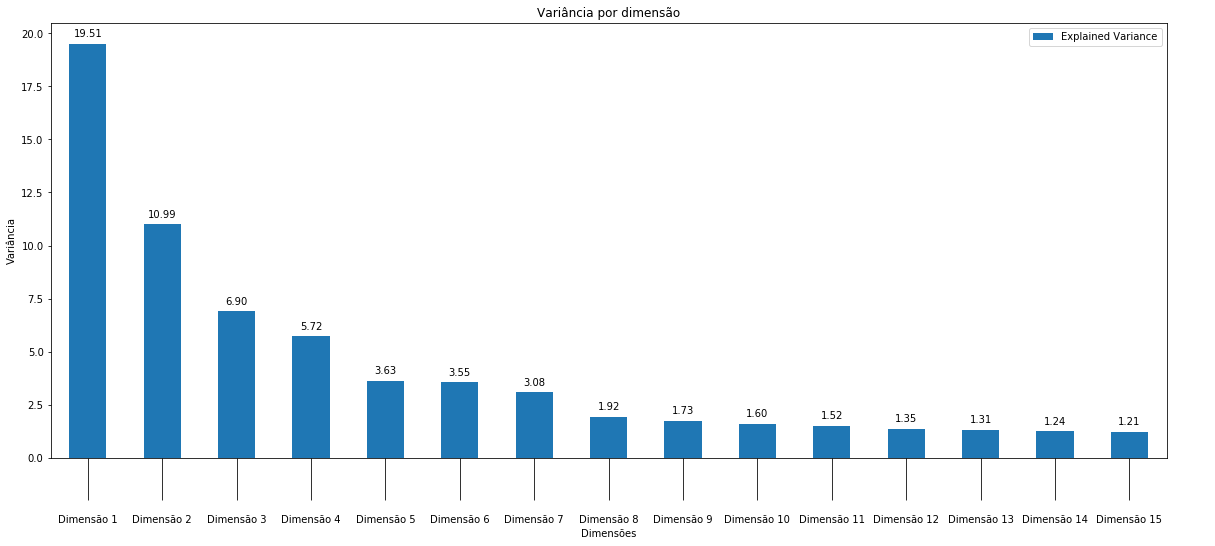

As dimensões juntas apresentam uma variação de 65.25%.


In [17]:
pca = grid.best_estimator_.named_steps['reduce_dim']
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
variance_ratios.index = ['Dimensão {}'.format(i) for i in range(1,len(pca.components_)+1)]

# plotando variação das dimensões
(variance_ratios *100).plot(kind="bar", figsize = (20, 8))
ax = plt.gca()
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2.,
                                        p.get_height()), ha='center',
                va='center', xytext=(0, 10), textcoords='offset points')
ax.tick_params(axis = 'x', which = 'major', pad = 15, size = 42)
ax.set_ylabel('Variância')
ax.set_xlabel('Dimensões')
plt.title("Variância por dimensão")
plt.setp(ax.get_xticklabels(), rotation = 0)
plt.show()

print('As dimensões juntas apresentam uma variação de {:.2f}%.'.format(np.sum(pca.explained_variance_ratio_) * 100))

Como podemos perceber na visualização acima, a taxa de variância cumulativa apresenta 65.25%, uma variância relativamente baixa já era esperado, já que menos dimensões implica em menor variância.

### Visualizando os Resultados

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.8s finished


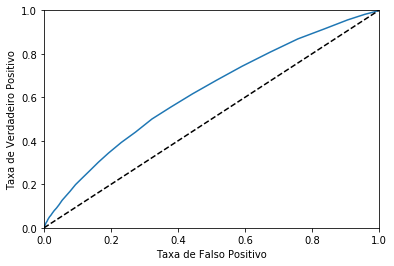

Score Rock: 62.1585%


In [39]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
y_probas = grid.best_estimator_.predict_proba(x_test)
y_scores = y_probas[:, 1] 

fpr1, tpr1, thresholds = roc_curve(y_test, y_scores)

plt.plot(fpr1, tpr1, linewidth=1.5, label=None)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.show()

print("Score Rock: {:.4f}%".format(roc_auc_score(y_test, y_scores)*100))

### Salvando classificador do PCA

In [20]:
with open('classifier_pca.pkl', "wb") as clf_outfile:
    pickle.dump(grid, clf_outfile)

### Carregando classificador

In [23]:
with open('classifier_pca.pkl', "rb") as clf_infile:
    clf = pickle.load(clf_infile)

In [40]:
gc.collect()

31427

In [41]:
pd.DataFrame(pca.components_,columns=x_train.columns)


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan
0,-0.008876,0.011009,0.016063,0.018585,0.016775,0.058950,-0.016986,-0.003999,-0.009447,-0.005771,...,0.000491,0.001686,-0.000140,0.022644,-0.002776,-0.002391,-0.019350,0.018967,-0.000816,-0.018151
1,0.013478,0.011906,0.005690,0.018377,0.005585,0.014587,0.039314,0.007686,0.016034,0.012932,...,-0.000086,-0.000036,0.000129,-0.003406,0.002302,0.000537,-0.000007,0.000201,0.000151,-0.000352
2,0.056777,-0.019727,-0.048821,-0.041325,-0.048475,-0.204713,0.136376,0.022274,0.063939,0.038816,...,0.000018,-0.000017,-0.000419,0.000326,-0.004591,0.000151,0.008554,-0.008366,0.000082,0.008284
3,0.093422,0.046026,0.040276,0.055392,0.040716,0.123745,0.241929,0.036307,0.094152,0.076594,...,0.000336,0.000993,0.000233,0.004227,0.000330,-0.000226,-0.007728,0.007849,-0.000131,-0.007718
4,-0.017866,0.080021,0.321523,0.272685,0.318252,-0.071571,-0.034790,-0.048589,0.006779,-0.007588,...,0.000512,0.001167,0.000113,0.015068,0.002497,-0.001240,-0.017806,0.017017,-0.000488,-0.016529
5,0.001526,0.033279,0.149673,0.124638,0.147461,0.033596,0.004146,-0.018928,-0.006565,0.005748,...,-0.000734,-0.001665,-0.000090,-0.023903,0.001972,0.003089,0.021124,-0.017218,0.001189,0.016029
6,-0.023056,-0.003226,-0.004933,-0.008306,-0.004860,-0.022826,-0.034793,-0.005495,-0.021380,-0.012296,...,0.000791,0.000307,0.000264,0.009617,0.008272,0.001805,-0.021796,0.030618,0.000599,-0.031217
7,-0.092760,0.436776,-0.052418,-0.005089,-0.047205,-0.026865,-0.019126,-0.006184,-0.007136,0.004825,...,0.000478,0.001740,0.000309,0.017777,0.020723,-0.000734,-0.041946,0.043393,-0.000329,-0.043064
8,-0.049497,0.170728,-0.001248,-0.004486,-0.002000,-0.029465,-0.017171,0.015596,0.002500,0.002767,...,-0.000009,0.000191,0.000115,-0.019005,-0.003404,0.003397,0.019265,-0.020398,0.001234,0.019164
9,-0.027880,0.119111,0.001693,0.006472,0.000103,0.018680,-0.009559,0.019857,-0.027846,0.012146,...,-0.001906,-0.006533,-0.000715,-0.029803,-0.052005,-0.000330,0.096742,-0.096445,0.000062,0.096383
